# 0. Project Overview 
## 0.1 What is DOTA?  
[DOTA](https://en.wikipedia.org/wiki/Dota_2) is an online multiplayer game which stands for Defense of the Ancients. The game is developped and published by valve and represents the second iteration of its kind. Originally, the game was developped by someone with the alias: "[IceFrog](https://dota2.gamepedia.com/IceFrog)" who published DOTA through a community-created mod using the Warcraft III engine.  

The game is played 5 vs. 5 on the same map every game. Each team must occupy and defend their own bases where resides 'the ancient'. The game ends when one team successfully destroys the ancient. Each player must independently control a powerful character also known as a hero. Each hero has a unique style of play and possesses on average 4 unique abilities. Throughout the gameplay, heros can accumulate gold and experience through combat versus the other team's heros, killing enemy creeps (NPC), or destroying enemy towers/structures.  

This game is regarded as having one of the steepest learning curves by the gaming community. Losing is extremely frustrating while winning feels extremely rewarding.  

## 0.2 Some DOTA History  
The game may seem simple at first glance due to each hero having access to only 4 skills, however the game is deceptively deep. The team composition permutations seem unumerable and every game is different from a previous one. Players with over 3000 hours of game time are still considered "Noobs" by the community.  

In 2017, Elon Musk assembled a team to create an AI capable of playing DOTA 2 matches known as [OpenAI](https://blog.openai.com/dota-2/). This AI was only designed to participate in 1 vs. 1 player matches in the "mid lane". This bot learned to play the hero known as "Nevermore" or by its title "ShadowFiend" and had the opportunity to demonstrate its skills against one of the best mid players in the world: [Dendi](https://liquipedia.net/dota2/Dendi). Needless to say, OpenAI crushed Dendi which resonated throughout the gaming community.  

Despite this victory, OpenAI is a very long way from learning to play 5 vs. 5 as it would have to learn every hero individually as well as team coordination strategies where the possibilities are seemingly endless.  


## 0.3 DOTA Trivia  
1. DOTA 2 generates \$18m per month
2. DOTA 2 holds the record for the largest prize pool in any e-sports at $24,687,919.00

## 0.4 Why DOTA?  
As mentioned in section 0.2, the game is quite complex during the play phase but this complexity is driven by the drafting phase. Before entering a game, players are presented at the hero selection screen where they can assemble a team of heroes with the goal of building as much synergy as possible. Certain teams favor pushing towers early in the game while other teams play for longevity thus giving the time and ressources for their heroes to become stronger. Regardless of a team's composition, the drafting phase will set the pace for the match.  

Drafting is known to be an art in the DOTA community since it is so difficult to execute correctly. Many games can be won or lost from this game phase.  

This research aims to find statistical evidence which will suggest to players which hero they should play/draft in order to maximize chances at victory.  

## 0.5 Questions
1. Given the hero selection screen, where some heros might already be drafted, which kind of should be drafted next to maximize victory? (Heros come in different kinds or with different roles)
2. Given a certain kind of hero, which one of these should be drafted given the players performances and experience?

## 0.6 Hypothesis & Expectations
1. The margin by which a team wins matters since we want to maximize the odds of victory (a conclusive and convincing victory). Therefore a heuristic needs to be found for player performance. 
2. With only 1000 matches there are a maximum of 10 000 unique players which is a lot of data to process for a notebook but not sufficient for a full research.
3. Players have a match making rating thus regrouping players of similar skills into the same matches. Despite some players climbing up or down the ladder to have their MMR reflect their skills, I assume that most players are ranked appropriately. This is important because we don't want ace/smurf players to skew the results by playing well with bad team compositions.

# 1. Data Collection  
The data collection isn't done through this notebook since it can be very lengthy in terms of time so it is done in a seperate script. Furthermore, the API used by the python code isn't supported by Anaconda. To collect the data set you must perform the following operations:
1. pip3 install -t ../dota2/requirements.txt
2. python3 ../dota2/src/api_wrapper.py  

The dataset will be saved in *../dota2/src/data/*  

## 1.1 Downloaded Files   
Below are the dynamic/up to date files. Running the script above will gather recent data from the DOTA 2 servers.  
[dota2api](http://dota2api.readthedocs.io/en/latest/index.html)
* match.json
* heroes.json
* items.json

[DOTABUFF](https://www.dotabuff.com/heroes/played)
* hero_monthly_stats.json

[Liquipedia](https://liquipedia.net/dota2/Hero_Roles)
* hero_complexity.txt
* hero_role.txt

[dota2lists](http://dota2lists.blogspot.com/2014/06/dota-2-hero-abbreviations.html)
* hero_abbreviations.txt

# 2 Data Discovery  
First and foremost, I am an experience player at this game which allows me to analyze the data easily and efficiently.  
The main data to use is the **match.json** file which is already well defined in a .json format. The **heroes.json** and **items.json** will compliment the former file. Finally, all other files will be used to enrich this information.

## 2.1 Analyzing match.json  


In [1]:
import json
import pandas as pd

# load match data
with open('data/match.json') as f:
    raw_match_data = json.load(f)

# display table head
match_df = pd.DataFrame(raw_match_data).transpose()
match_df.head()

,barracks_status_dire,barracks_status_radiant,cluster,cluster_name,dire_captain,dire_score,duration,engine,first_blood_time,flags,...,picks_bans,players,positive_votes,pre_game_duration,radiant_captain,radiant_score,radiant_win,start_time,tower_status_dire,tower_status_radiant
3933472394,63,0,133,Europe West,NaN,38,1620,1,70,1,...,"[{'order': 0, 'hero_id': 22, 'team': 0, 'is_pi...","[{'gold_per_min': 392, 'leaver_status_name': '...",0,60,NaN,29,False,1528135877,1958,0
3933472395,63,0,227,NaN,NaN,35,2300,1,157,1,...,"[{'order': 0, 'hero_id': 99, 'team': 0, 'is_pi...","[{'gold_per_min': 553, 'leaver_status_name': '...",0,90,NaN,31,False,1528135882,1974,0
3933472396,63,0,183,Russia,NaN,5,781,1,142,1,...,"[{'order': 0, 'hero_id': 32, 'team': 0, 'is_pi...","[{'gold_per_min': 537, 'leaver_status_name': '...",0,60,NaN,9,NaN,1528135876,2039,0
3933472397,0,63,185,Russia,NaN,27,2277,1,129,1,...,"[{'order': 0, 'hero_id': 56, 'team': 0, 'is_pi...","[{'gold_per_min': 444, 'leaver_status_name': '...",0,90,NaN,54,True,1528135877,0,1975
3933472398,0,55,187,Russia,NaN,46,2291,1,50,1,...,"[{'order': 0, 'hero_id': 56, 'team': 0, 'is_pi...","[{'gold_per_min': 508, 'leaver_status_name': '...",0,90,NaN,44,True,1528135875,0,1926


We notice there are 2 columns with dictionaries: **picks_bans** and **players**. We can expand both of their fields to further investigate their contents.  

We also print out all the columns and eyeball their names to make sure we don't miss anything unusual.

In [2]:
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_score', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_score', 'radiant_win', 'start_time', 'tower_status_dire',
       'tower_status_radiant'],
      dtype='object')

## 2.1 Breaking down the matches.json  
### 2.1.1  Analyzing the player key
We first investigate the **players** key

In [3]:
index = match_df.index[0]
type(match_df.loc[index]['players'])

list

The player column is a list of players and therefore we will only display the values for the first item in the collection.

In [4]:
match_df.loc[index]['players'][0]

{'ability_upgrades': [{'ability': 5011, 'level': 1, 'time': 201},
  {'ability': 5014, 'level': 2, 'time': 201},
  {'ability': 5011, 'level': 3, 'time': 274},
  {'ability': 5014, 'level': 4, 'time': 347},
  {'ability': 5011, 'level': 5, 'time': 413},
  {'ability': 5013, 'level': 6, 'time': 498},
  {'ability': 5014, 'level': 7, 'time': 519},
  {'ability': 5011, 'level': 8, 'time': 547},
  {'ability': 5014, 'level': 9, 'time': 574},
  {'ability': 6003, 'level': 10, 'time': 621},
  {'ability': 5013, 'level': 11, 'time': 809},
  {'ability': 5012, 'level': 12, 'time': 820},
  {'ability': 5012, 'level': 13, 'time': 855},
  {'ability': 5012, 'level': 14, 'time': 857},
  {'ability': 6826, 'level': 15, 'time': 955},
  {'ability': 5012, 'level': 16, 'time': 977},
  {'ability': 5013, 'level': 17, 'time': 1145},
  {'ability': 6068, 'level': 18, 'time': 1267}],
 'account_id': 119063051,
 'assists': 14,
 'backpack_0': 0,
 'backpack_1': 237,
 'backpack_2': 57,
 'deaths': 7,
 'denies': 3,
 'gold': 715,

**Players column review**  
From the point of view of someone who has played hundreds of hours of DOTA, I can confirm that there is 2 types of information present in this column.  
1. A player's performance with a hero --> gold per minute, kills, deaths...
2. a player's choices throughout the game --> item selection, ability upgrades... 
This knowledge is usefull in order to determine what will need to be dropped later on.

### 2.1.1  Analyzing the pick_bans column

In [5]:
match_df.loc[index]['picks_bans'][0]

{'hero_id': 22, 'is_pick': False, 'order': 0, 'team': 0}

**picks_bans review**  
As expected, this column isn't too important for our purpose. Dota allows different game modes, one from which, captains on both teams can choose and ban certain heros from the draft in a sequential manner instead of a "free-for-all". This column is only useful if we investigate that particular game mode which is not in the scope of this research.

## 2.2 Analyzing the items.json
This data was recovered from the API since there are keys from the **match.json** files which points to this. From my hypothesis I do not think this will be very important as items are correlated with in-game decisions as opposed to drafting.

In [6]:
with open('data/items.json') as f:
    raw_item_data = json.load(f)

In [7]:
item_df = pd.DataFrame(raw_item_data)
item_df.head()

,items,status
0,"{'id': 1, 'localized_name': 'Blink Dagger', 'n...",200
1,"{'id': 2, 'localized_name': 'Blades of Attack'...",200
2,"{'id': 3, 'localized_name': 'Broadsword', 'nam...",200
3,"{'id': 4, 'localized_name': 'Chainmail', 'name...",200
4,"{'id': 5, 'localized_name': 'Claymore', 'name'...",200


Once again we are confronted with a dictionary inside a column so we can investigate it further.

In [8]:
item_df.loc[0]['items']

{'cost': 2250,
 'id': 1,
 'localized_name': 'Blink Dagger',
 'name': 'item_blink',
 'recipe': 0,
 'secret_shop': 0,
 'side_shop': 1,
 'url_image': 'http://cdn.dota2.com/apps/dota2/images/items/blink_lg.png'}

There doesn't seem to be any interesting information in this data.

## 2.3 Analyzing the heroes.json

In [9]:
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
hero_df = pd.DataFrame(raw_hero_data)
hero_df.head()

,count,heroes,status
0,115,{'url_small_portrait': 'http://cdn.dota2.com/a...,200
1,115,{'url_small_portrait': 'http://cdn.dota2.com/a...,200
2,115,{'url_small_portrait': 'http://cdn.dota2.com/a...,200
3,115,{'url_small_portrait': 'http://cdn.dota2.com/a...,200
4,115,{'url_small_portrait': 'http://cdn.dota2.com/a...,200


In [10]:
hero_df.loc[0]['heroes']

{'id': 1,
 'localized_name': 'Anti-Mage',
 'name': 'npc_dota_hero_antimage',
 'url_full_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_full.png',
 'url_large_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_lg.png',
 'url_small_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_sb.png',
 'url_vertical_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_vert.jpg'}

This information is interesting for the hero unique ID and name. The rest of the information can be dropped.

## 2.4 Analyzing game complexity  
One interesting aspect with the hero list and item list is that we can determine the quantity of theorycrafts possible.

In [11]:
import math
item_count = len(raw_item_data['items'])
heroes_count = len(raw_hero_data['heroes'])
heroes_per_game = 10

# hero combinations without repetition
numerator = math.factorial(heroes_count)
denominator = math.factorial(heroes_per_game) * math.factorial(heroes_count - heroes_per_game)
hero_combinations = numerator // denominator

# item combinations with repetition
# A hero can have 0 to 6 items so we calculate the permutations for every number of items
item_combinations = 0
for items_per_hero in range(7):
    numerator = math.factorial(item_count + items_per_hero - 1)
    denominator = math.factorial(item_count - 1) * math.factorial(items_per_hero)
    item_combinations += numerator // denominator

print(hero_combinations)
print(item_combinations)

74540394223878
607221379765


**Theorycrafting**  
There is an astonishing **74540394223878** ways of drafting heroes with **607221379765** item combinations for **each** hero drafed!

In [12]:
# Theorycraft combinations
theory_craft_combination = hero_combinations * item_combinations
print(theory_craft_combination)
'{:.2e}'.format(theory_craft_combination)

45262521028850235469028670


'4.53e+25'

Finally we find that there are **4.53 * 10^25** theoretical hero setups. This is excluding ability upgrades so there are in fact more. This number alone raises questions about the performance of a statistical tool which can help us evaluate this problem given that the research is conducted on only 1000 data points. For this reason I have decided to classify the heroes into smaller categories.

## 2.5 Reducing game complexity with data classification  
Thankfully, professional players have already done the classification for us. It is only a matter of scrapping the wikipedia page and cleaning the data.

### 2.5.1 Analyzing hero roles

In [13]:
file = open('data/hero_role.txt', 'r')
raw_hero_role_data = ""
for line in file:
    raw_hero_role_data += line
file.close()
print(raw_hero_role_data[:1000])

{| class="wikitable"
!colspan=8| ■■■ Carry
|-
|{{HeroIcon|am}}{{HeroIcon|arc}}{{HeroIcon|ck}}{{HeroIcon|gyro}}{{HeroIcon|medusa}}{{HeroIcon|morph}}{{HeroIcon|naga}}{{HeroIcon|pa}}<br>{{HeroIcon|sniper}}{{HeroIcon|spectre}}{{HeroIcon|tb}}{{HeroIcon|tiny}}{{HeroIcon|troll}}
|-
!colspan=8| ■■ Carry
|-
|{{HeroIcon|alch}}{{HeroIcon|bb}}{{HeroIcon|dk}}{{HeroIcon|huskar}}{{HeroIcon|ls}}{{HeroIcon|lycan}}{{HeroIcon|mk}}{{HeroIcon|slardar}}<br>{{HeroIcon|sven}}{{HeroIcon|wk}}{{HeroIcon|clinkz}}{{HeroIcon|drow}}{{HeroIcon|ember}}{{HeroIcon|void}}{{HeroIcon|jugg}}{{HeroIcon|ld}}<br>{{HeroIcon|luna}}{{HeroIcon|meepo}}{{HeroIcon|pl}}{{HeroIcon|razor}}{{HeroIcon|riki}}{{HeroIcon|sf}}{{HeroIcon|slark}}{{HeroIcon|ta}}<br>{{HeroIcon|ursa}}{{HeroIcon|weaver}}{{HeroIcon|od}}{{HeroIcon|storm}}{{HeroIcon|pangolier}}
|-
!colspan=8| ■ Carry
|-
|{{HeroIcon|abaddon}}{{HeroIcon|brew}}{{HeroIcon|doom}}{{HeroIcon|kunkka}}{{HeroIcon|lc}}{{HeroIcon|ns}}{{HeroIcon|sb}}{{HeroIcon|bs}}<br>{{HeroIcon|brood}}{{HeroIcon|

**Hero Role review**  
The data is absolutely disgusting to look at but we notice some level of formatting. According to the wikipedia article the number of '■' represent the degree at which a hero belongs to a class. The name appearing right after the '■' symbol is the class. All items listed under the class are the heroes belonging to it.

In [14]:
delimeter_start = "■■■ "
delimeter_end = "\n|-\n|"
delimited_roles = raw_hero_role_data.split(delimeter_start)
roles_list = []
for dr in delimited_roles:
    roles_list.append(dr.split(delimeter_end)[0])
roles_list = roles_list[1:]
print(roles_list)

['Carry', 'Nuker', 'Initiator', 'Disabler', 'Escape', 'Support', 'Pusher', 'Jungler']


The above script prints out all the different hero roles and after inspection they seem correct.

### 2.5.2 Analyzing hero complexity

In [15]:
file = open('data/hero_complexity.txt')
raw_hero_complexity_data = ""
for line in file:
    raw_hero_complexity_data += line
file.close()
print(raw_hero_complexity_data[500:1000])

y styles.

{| class="wikitable"
!colspan=8| ■■■ Complexity
|-
|{{HeroIcon|brewmaster}}{{HeroIcon|earth spirit}}{{HeroIcon|io}}{{HeroIcon|aw}}{{HeroIcon|ld}}{{HeroIcon|meepo}}{{HeroIcon|morph}}{{HeroIcon|chen}}<br>{{HeroIcon|invoker}}{{HeroIcon|oracle}}{{HeroIcon|rubick}}{{HeroIcon|storm}}{{HeroIcon|visage}}
|-
!colspan=8| ■■ Complexity
|-
|{{HeroIcon|beastmaster}}{{HeroIcon|clock}}{{HeroIcon|doom}}{{HeroIcon|earthshaker}}{{HeroIcon|et}}{{HeroIcon|kunkka}}{{HeroIcon|lifestealer}}{{HeroIcon|lycan}


**Complexity review**  
This file has the same structure as the former one although I doubt that this data will be any usefull for the research. A hero can be very hard to play for most players but very easy for few players. For this reason, it is more adequate to look at a player's win ratio history with a select hero than to generalize how well a person will play given the general distribution.

# 3 Cleaning data & Structuring  
This is enough data discovery, by now we have a good idea of what it represents. Now we must clean and structure the data so that it is easily usable by statistical and analytical tools later on.

## 3.1 Cleaning hero data 
### 3.1.1 Adding delimiters
From the above section, the most unformatted data is the hero_roles.txt file. I first start of by removing all unecessary text and creating '|' delimiters which will become easy to regex.

In [16]:
updated_hero_role_data = ""
updated_hero_role_data = raw_hero_role_data.replace("{{HeroIcon|", "|")
updated_hero_role_data = updated_hero_role_data.replace("}}", "| ")
updated_hero_role_data = updated_hero_role_data.replace("|-\n", "")
updated_hero_role_data = updated_hero_role_data.replace("<br>", "")
print(updated_hero_role_data[:500])

{| class="wikitable"
!colspan=8| ■■■ Carry
||am| |arc| |ck| |gyro| |medusa| |morph| |naga| |pa| |sniper| |spectre| |tb| |tiny| |troll| 
!colspan=8| ■■ Carry
||alch| |bb| |dk| |huskar| |ls| |lycan| |mk| |slardar| |sven| |wk| |clinkz| |drow| |ember| |void| |jugg| |ld| |luna| |meepo| |pl| |razor| |riki| |sf| |slark| |ta| |ursa| |weaver| |od| |storm| |pangolier| 
!colspan=8| ■ Carry
||abaddon| |brew| |doom| |kunkka| |lc| |ns| |sb| |bs| |brood| |mirana| |viper| |dp| |invoker| |leshrac| |lina| |np| |n


### 3.1.2 Regex  
The next step is to regex all the hero names. We notice from the names that there are acronyms such as "ck" which actually stands for "Chaos Knight". Comparing these values with the ones form the hero.json file will create inconsistencies. Therefore we need another set of data which will translate these common acronyms to the hero's actual name.

In [17]:
import re
hero_regex = re.compile("\|.*\|")
hero_regex_matches = re.findall(hero_regex, updated_hero_role_data)
for i in range(len(hero_regex_matches)):
    hero_regex_matches[i] = hero_regex_matches[i].replace("|", ", ")
print(hero_regex_matches)

[', , am,  , arc,  , ck,  , gyro,  , medusa,  , morph,  , naga,  , pa,  , sniper,  , spectre,  , tb,  , tiny,  , troll, ', ', , alch,  , bb,  , dk,  , huskar,  , ls,  , lycan,  , mk,  , slardar,  , sven,  , wk,  , clinkz,  , drow,  , ember,  , void,  , jugg,  , ld,  , luna,  , meepo,  , pl,  , razor,  , riki,  , sf,  , slark,  , ta,  , ursa,  , weaver,  , od,  , storm,  , pangolier, ', ', , abaddon,  , brew,  , doom,  , kunkka,  , lc,  , ns,  , sb,  , bs,  , brood,  , mirana,  , viper,  , dp,  , invoker,  , leshrac,  , lina,  , np,  , necro,  , qop,  , silencer,  , tinker,  , wr, ', ', , phoenix,  , timber,  , sf,  , invoker,  , lesh,  , lina,  , lion,  , oracle,  , qop,  , skywrath,  , techies,  , tinker,  , zeus, ', ', , earth spirit,  , sk,  , tiny,  , luna,  , meepo,  , nyx,  , cm,  , jakiro,  , kotl,  , lich,  , necro,  , ogre,  , od,  , puck,  , pugna,  , shaman,  , storm,  , visage,  , wd,  , pangolier,  , dark willow, ', ', , alch,  , beastmaster,  , brew,  , bb,  , centaur,  ,

### 3.1.3  Inspecting the hero_abbreviations.txt
We inspect this file quickly to understand its format so that we can use it.

In [18]:
file = open("data/hero_abbreviations.txt", 'r')
sample = ""
for line in file:
    sample += line
file.close()
print(sample[:100])

Abaddon
Alch = Alchemist
AA = Ancient Apparition
AM = Anti-Mage
Arc = Arc Warden
Axe
Bane
Bat = Batr


The file is formatted in a very simple manner. Hero abbreviations are mapped to their actual names and heroes without abbreviations are simply not mapped. For this task we can simply create a dictionary which will map abbreviations to actual names.

In [19]:
# load data
file = open("data/hero_abbreviations.txt", 'r')
hero_abbr = {}
for line in file:
    txt = line.lower()
    # split with '='. Left hand side is abbreviation
    key = txt.split(' =')[0]
    try:
        # right hand side is hero full name
        value = txt.split('= ')[1]
        value = value.replace("\n", "")        
    except IndexError:
        key = key.replace("\n", "")
        value = key        
    hero_abbr[key] = value
    hero_abbr[value] = value
file.close()
print(hero_abbr)

{'abaddon': 'abaddon', 'alch': 'alchemist', 'alchemist': 'alchemist', 'aa': 'ancient apparition', 'ancient apparition': 'ancient apparition', 'am': 'anti-mage', 'anti-mage': 'anti-mage', 'arc': 'arc warden', 'arc warden': 'arc warden', 'axe': 'axe', 'bane': 'bane', 'bat': 'batrider', 'batrider': 'batrider', 'bm': 'beastmaster', 'beastmaster': 'beastmaster', 'beast': 'beastmaster', 'bs': 'bloodseeker', 'bloodseeker': 'bloodseeker', 'bh': 'bounty hunter', 'bounty hunter': 'bounty hunter', 'brew': 'brewmaster', 'brewmaster': 'brewmaster', 'bb': 'bristleback', 'bristleback': 'bristleback', 'brood': 'broodmother', 'broodmother': 'broodmother', 'centaur': 'centaur warrunner', 'centaur warrunner': 'centaur warrunner', 'cent': 'centaur warrunner', 'ck': 'chaos knight', 'chaos knight': 'chaos knight', 'chen': 'chen', 'clinkz': 'clinkz', 'clock': 'clockwerk', 'clockwerk': 'clockwerk', 'cm': 'crystal maiden', 'crystal maiden': 'crystal maiden', 'ds': 'dark seer', 'dark seer': 'dark seer', 'dazzle

### 3.1.4 Mapping abbreviations to full names  
The above output shows us the content of the dictionary. We can now use this to map hero abbreviations to their full names so that they match the rest of the dataset.

In [20]:
cleaned_hero_names = []
for i in range(len(hero_regex_matches)):
    line = hero_regex_matches[i].split(", ")        
    tmp_list = []
    for j in range(len(line)):
        if line[j] == ' ' or line[j] == '':
            pass
        else:
            tmp_list.append(hero_abbr[line[j]])
    cleaned_hero_names.append(tmp_list)
print(cleaned_hero_names)

[['anti-mage', 'arc warden', 'chaos knight', 'gyrocopter', 'medusa', 'morphling', 'naga siren', 'phantom assassin', 'sniper', 'spectre', 'terrorblade', 'tiny', 'troll warlord'], ['alchemist', 'bristleback', 'dragon knight', 'huskar', 'lifestealer', 'lycan', 'monkey king', 'slardar', 'sven', 'wraith king', 'clinkz', 'drow ranger', 'ember spirit', 'faceless void', 'juggernaut', 'lone druid', 'luna', 'meepo', 'phantom lancer', 'razor', 'riki', 'shadow fiend', 'slark', 'templar assassin', 'ursa', 'weaver', 'outworld devourer', 'storm spirit', 'pangolier'], ['abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger'], ['phoenix', 'timbersaw', 'shadow fiend', 'invoker', 'leshrac', 'lina', 'lion', 'oracle', 'queen of pain', 'skywrath mage', 'techies', 'tinker', 'zeus'], ['eart

**Output**  
The above code generates a list of all the heroes by their roles in the same order in which they appear from the wikipedia dataset. --> [carry:[hero_1, hero_2], support:[hero_n], ...]. There are no errors during runtime which tells us that every hero has been mapped appropriately.

### 3.1.5 Structuring hero roles  
The final step is the create a dictionary which will map roles to a list of heroes which can then easily be used by pandas to create a dataframe. From the dataset we notice a sequence --> <hard, semi, weak> <role>. So every 3rd element in a list has the same magnitude (hard, semi, weak). After 3 elements, the role is updated.

In [21]:
cleaned_roles_dict = {}
role_index = -1
for i in range(len(cleaned_hero_names)):    
    role_strength = i % 3    

    if role_strength == 0:
        role_index += 1
    hard_role = roles_list[role_index].lower()
    cleaned_roles_dict[hard_role] = cleaned_hero_names[i]
            
print(cleaned_roles_dict)

{'carry': ['abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger'], 'nuker': ['alchemist', 'beastmaster', 'brewmaster', 'bristleback', 'centaur warrunner', 'clockwerk', 'doom', 'dragon knight', 'earthshaker', 'elder titan', 'io', 'kunkka', 'legion commander', 'magnus', 'night stalker', 'omniknight', 'pudge', 'sven', 'tidehunter', 'tusk', 'undying', 'anti-mage', 'arc warden', 'bloodseeker', 'bounty hunter', 'broodmother', 'ember spirit', 'gyrocopter', 'mirana', 'morphling', 'phantom lancer', 'razor', 'slark', 'sniper', 'terrorblade', 'vengeful spirit', 'venomancer', 'ancient apparition', 'bane', 'dazzle', 'death prophet', 'disruptor', "nature's prophet", 'rubick', 'shadow demon', 'silencer', 'underlord', 'windranger', 'winter wyvern'], 'initiator': ['alchemist', 'bri

**Validating output**  
After a quick glance and comparison with the dataset, the dictionary seems to have been created appropriately and therefore the cleaning has been successful.

### 3.1.6 Representing roles by integers  
The machine learning model will need integers instead of strings. Also notice that certain heroes fit more than 1 role because they can be played differently. For this reason every hero is represented by a 24 bit number where every bit represents a role.

In [22]:
role_bits = {
    'role': {}
}

index = 0
for role in cleaned_roles_dict:
    role_bits['role'][role] = index
    index += 1
role_bits_df = pd.DataFrame(role_bits)     
role_bits_df.head()

,role
carry,0
disabler,3
escape,4
initiator,2
jungler,7


We then save the roles ad their associated bits to a .json file for use later if necessary.m

In [23]:
with open('data/role_bits.json', 'w') as outfile:
    json.dump(role_bits, outfile)

### 3.1.7 Structuring the hero roles  
In order to maximize informaiton, I have decided to also represent every hero's role by a 1 hot vector.

In [24]:
hero_roles_dict = {}
for key in cleaned_roles_dict:
    for hero in cleaned_roles_dict[key]:
        if hero in hero_roles_dict:
            hero_roles_dict[hero]['score'] += 2**role_bits['role'][key]            
        else:
            hero_roles_dict[hero] = {
                'score': 2**role_bits['role'][key],
                'carry': 0, 
                'disabler': 0, 
                'escape': 0, 
                'initiator': 0,
                'jungler': 0, 
                'nuker': 0, 
                'pusher': 0, 
                'support': 0
            }
        hero_roles_dict[hero][key] = 1
hero_scores_df = pd.DataFrame(hero_roles_dict).transpose()
hero_scores_df = hero_scores_df.reset_index()
hero_scores_df = hero_scores_df.rename({'index':'hero_name'}, axis='columns')
hero_scores_df.head()

,hero_name,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,1,0,0,0,0,0,0,1,0
1,alchemist,0,1,0,1,0,1,0,46,1
2,ancient apparition,0,1,0,0,0,1,0,10,0
3,anti-mage,0,0,0,0,0,1,0,2,0
4,arc warden,0,0,0,0,0,1,0,2,0


### 3.1.8 Merging hero unique id  
Finally we merge the hero unique id to this table so that it can correspond to the rest of the set. We also take the luxury of dropping the unecessary columns listed in section 2.

In [25]:
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
    
hero_roles_dict = {
    'hero': {}
}

hero_list = raw_hero_data['heroes']

for dictionary in hero_list:
    dictionary['localized_name'] = dictionary['localized_name'].lower()            
    hero_name = dictionary['localized_name']    

hero_roles_df = pd.DataFrame(hero_list) 
hero_roles_df = hero_roles_df.reset_index()

# rename columns to fit rest of dataset
hero_roles_df = hero_roles_df.rename({'localized_name':'hero_name','id': 'hero_id'}, axis='columns')

# columns to drop
drop_columns = [
    'name',
    'url_full_portrait',
    'url_large_portrait',
    'url_small_portrait',
    'url_vertical_portrait',
    'index'
]
hero_roles_df = hero_roles_df.drop(columns=drop_columns)
hero_roles_df.head()

,hero_id,hero_name
0,1,anti-mage
1,2,axe
2,3,bane
3,4,bloodseeker
4,5,crystal maiden


Finally we can merge this table right above with the hero roles based on their names.

In [26]:
hero_roles_df = pd.merge(hero_roles_df, hero_scores_df, on='hero_name')
hero_roles_df.head()

,hero_id,hero_name,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,1,anti-mage,0,0,0,0,0,1,0,2,0
1,3,bane,0,0,0,0,0,1,0,2,0
2,4,bloodseeker,1,1,0,1,1,1,0,143,0
3,5,crystal maiden,0,0,0,0,1,0,0,128,0
4,6,drow ranger,0,1,0,0,0,0,1,72,0


In [27]:
with open('data/hero_roles.json', 'w') as outfile:
    outfile.write(hero_roles_df.to_json(orient='records', lines=True))

The merge was successfull! All heroes are now identified by their roles and unique identifiers. We can save this file for use later.

## 3.2 Cleaning Match data  
### 3.2.1 Match meta data
We first show the match_df header to refresh our memory on this dataset. 

In [28]:
match_df = pd.DataFrame(raw_match_data)
match_df = match_df.transpose()
match_df.head()

,barracks_status_dire,barracks_status_radiant,cluster,cluster_name,dire_captain,dire_score,duration,engine,first_blood_time,flags,...,picks_bans,players,positive_votes,pre_game_duration,radiant_captain,radiant_score,radiant_win,start_time,tower_status_dire,tower_status_radiant
3933472394,63,0,133,Europe West,NaN,38,1620,1,70,1,...,"[{'order': 0, 'hero_id': 22, 'team': 0, 'is_pi...","[{'gold_per_min': 392, 'leaver_status_name': '...",0,60,NaN,29,False,1528135877,1958,0
3933472395,63,0,227,NaN,NaN,35,2300,1,157,1,...,"[{'order': 0, 'hero_id': 99, 'team': 0, 'is_pi...","[{'gold_per_min': 553, 'leaver_status_name': '...",0,90,NaN,31,False,1528135882,1974,0
3933472396,63,0,183,Russia,NaN,5,781,1,142,1,...,"[{'order': 0, 'hero_id': 32, 'team': 0, 'is_pi...","[{'gold_per_min': 537, 'leaver_status_name': '...",0,60,NaN,9,NaN,1528135876,2039,0
3933472397,0,63,185,Russia,NaN,27,2277,1,129,1,...,"[{'order': 0, 'hero_id': 56, 'team': 0, 'is_pi...","[{'gold_per_min': 444, 'leaver_status_name': '...",0,90,NaN,54,True,1528135877,0,1975
3933472398,0,55,187,Russia,NaN,46,2291,1,50,1,...,"[{'order': 0, 'hero_id': 56, 'team': 0, 'is_pi...","[{'gold_per_min': 508, 'leaver_status_name': '...",0,90,NaN,44,True,1528135875,0,1926


In [29]:
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_score', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_score', 'radiant_win', 'start_time', 'tower_status_dire',
       'tower_status_radiant'],
      dtype='object')

### 3.2.2 Droping columns
From the list above we notice that quite a few columns are not necessary for further analysis

In [30]:
drop_list = [
    'dire_captain', 
    'cluster', 
    'cluster_name', 
    'engine', 
    'match_seq_num', 
    'negative_votes', 
    'positive_votes',
    'lobby_type',
    'start_time',
    'radiant_captain',
    'pre_game_duration',    
    'lobby_name',
    'leagueid',
    'flags',
    'game_mode_name',
    'game_mode',
    'first_blood_time',
    'match_id',
    'players',
    'picks_bans'
]
match_df = match_df.drop(columns = drop_list)
match_df = match_df.reset_index()
match_df = match_df.rename({'index':'match_id'}, axis='columns')
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_score,duration,human_players,radiant_score,radiant_win,tower_status_dire,tower_status_radiant
0,3933472394,63,0,38,1620,10,29,False,1958,0
1,3933472395,63,0,35,2300,10,31,False,1974,0
2,3933472396,63,0,5,781,10,9,NaN,2039,0
3,3933472397,0,63,27,2277,10,54,True,0,1975
4,3933472398,0,55,46,2291,10,44,True,0,1926


### 3.2.3 Removing bad data  
1. From the information presented above, the only data we want to remove are games in which there are less than 10 players. Since DOTA is a 5v5 game then have less players will skew the results.  
2. Remove data where radiant_win is undefined

In [31]:
match_df = match_df.dropna(subset = ['radiant_win'])
match_df = match_df[match_df['human_players'] == 10]
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_score,duration,human_players,radiant_score,radiant_win,tower_status_dire,tower_status_radiant
0,3933472394,63,0,38,1620,10,29,False,1958,0
1,3933472395,63,0,35,2300,10,31,False,1974,0
3,3933472397,0,63,27,2277,10,54,True,0,1975
4,3933472398,0,55,46,2291,10,44,True,0,1926
5,3933472399,0,51,48,2861,10,50,True,0,1798


# 4. Data Enriching  
## 4.1 Creating player dataframe  
The player data wasn't kept in the match dataframe although it is useful to us. So we can create a new player dataframe with one of the columns pointing to the match id in which this player participated.

In [32]:
with open('data/match.json') as f:
    raw_match_data = json.load(f)

player_list = []

for keys in raw_match_data:
    for i in range(len(raw_match_data[keys]['players'])):        
        try:
            del raw_match_data[keys]['players'][i]['ability_upgrades']                
        except KeyError:
            pass 
        raw_match_data[keys]['players'][i]['match_id'] = keys        
        player_list.append(raw_match_data[keys]['players'][i])
    
players_df = pd.DataFrame(player_list)
players_df.head()

,account_id,additional_units,assists,backpack_0,backpack_1,backpack_2,deaths,denies,gold,gold_per_min,...,leaver_status_description,leaver_status_name,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,tower_damage,xp_per_min
0,1.674159e+08,NaN,18,46,0,0,8,2,833,382,...,"finished match, no abandon",NONE,25,3933472768,0,12976,152,58,66,648
1,4.294967e+09,NaN,9,0,212,0,9,7,2498,377,...,"finished match, no abandon",NONE,22,3933472768,1,4790,0,194,261,469
2,4.294967e+09,NaN,12,0,0,0,11,3,157,326,...,"finished match, no abandon",NONE,21,3933472768,2,7562,0,161,219,413
3,3.143901e+08,NaN,5,0,0,0,7,10,316,595,...,"finished match, no abandon",NONE,25,3933472768,3,17834,0,2011,3039,779
4,2.552884e+08,NaN,11,40,212,182,13,8,4782,428,...,"finished match, no abandon",NONE,25,3933472768,4,12834,0,110,223,612


In [33]:
players_df.columns

Index(['account_id', 'additional_units', 'assists', 'backpack_0', 'backpack_1',
       'backpack_2', 'deaths', 'denies', 'gold', 'gold_per_min', 'gold_spent',
       'hero_damage', 'hero_healing', 'hero_id', 'hero_name', 'item_0',
       'item_0_name', 'item_1', 'item_1_name', 'item_2', 'item_2_name',
       'item_3', 'item_3_name', 'item_4', 'item_4_name', 'item_5',
       'item_5_name', 'kills', 'last_hits', 'leaver_status',
       'leaver_status_description', 'leaver_status_name', 'level', 'match_id',
       'player_slot', 'scaled_hero_damage', 'scaled_hero_healing',
       'scaled_tower_damage', 'tower_damage', 'xp_per_min'],
      dtype='object')

### 4.1.2 Removing unecessary columns

In [34]:
drop_columns = [
    'leaver_status_description',
    'leaver_status_name',    
    'item_0_name',
    'item_1_name',
    'item_2_name',
    'item_3_name',
    'item_4_name',
    'item_5_name',
    'item_0',
    'item_1',
    'item_2',
    'item_3',
    'item_4',
    'item_5',
    'backpack_0',
    'backpack_1',
    'backpack_2',
    'hero_damage',
    'hero_healing',
    'tower_damage',
    'additional_units',
    'leaver_status'
]

players_df = players_df.drop(columns = drop_columns)
players_df.columns

Index(['account_id', 'assists', 'deaths', 'denies', 'gold', 'gold_per_min',
       'gold_spent', 'hero_id', 'hero_name', 'kills', 'last_hits', 'level',
       'match_id', 'player_slot', 'scaled_hero_damage', 'scaled_hero_healing',
       'scaled_tower_damage', 'xp_per_min'],
      dtype='object')

### 4.2.3 Dropping/Formatting bad data
If an account ID or a hero name is unadentified then we drop the data entirely. Additionally, we change the hero names to lower case and change the account_id column from float to integer.

In [35]:
players_df = players_df.dropna(subset = ['account_id'])
players_df = players_df.dropna(subset = ['hero_name'])
players_df['account_id'] = players_df['account_id'].astype(int)
players_df['hero_name'] = players_df['hero_name'].str.lower()
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,last_hits,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min
0,167415941,18,8,2,833,382,16355,71,spirit breaker,9,119,25,3933472768,0,12976,152,58,648
1,4294967295,9,9,7,2498,377,13655,6,drow ranger,1,243,22,3933472768,1,4790,0,194,469
2,4294967295,12,11,3,157,326,14470,88,nyx assassin,5,37,21,3933472768,2,7562,0,161,413
3,314390062,5,7,10,316,595,26815,106,ember spirit,12,377,25,3933472768,3,17834,0,2011,779
4,255288415,11,13,8,4782,428,14675,93,slark,8,217,25,3933472768,4,12834,0,110,612


## 4.2 Enriching Hero data frame
### 4.2.1 Community Monthly stats per heroes  
Some players have their stats hidden and therefore their past performances cannot be scraped. For this reason I have decided to scrape the average monthly performance of all dota users by heroes. This data will be used later to fix missing information for a players performance when needed. Because I created this dataset, there isn't much formatting to be done except for renaming certain column names so that it won't be confused later with the rest of the data.

In [36]:
with open('data/hero_monthly_stats.json') as f:
    hero_monthly_stats = json.load(f)
hero_monthly_stats_df = pd.DataFrame(hero_monthly_stats).transpose()
hero_monthly_stats_df = hero_monthly_stats_df.reset_index()
hero_monthly_stats_df = hero_monthly_stats_df.rename({
    'index':'hero_name', 
    'games_played':'hero_games_played',
    'kda':'hero_kda',
    'win_ratio':'hero_win_ratio'
    }, axis='columns')
hero_monthly_stats_df['hero_name'] = hero_monthly_stats_df['hero_name'].str.lower()
hero_monthly_stats_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio
0,abaddon,813552,2.7662,3.8269,53.147
1,alchemist,1002710,2.1533,4.7167,47.2532
2,ancient apparition,1444245,2.9395,6.7937,52.3461
3,anti-mage,2937612,2.4398,13.8186,49.2443
4,arc warden,393944,2.5933,1.8531,47.1554


### 4.2.2 Merging hero monthly stats with hero roles

In [37]:
hero_df = pd.merge(hero_monthly_stats_df, hero_roles_df, on='hero_name')
hero_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio,hero_id,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,813552,2.7662,3.8269,53.147,102,1,0,0,0,0,0,0,1,0
1,alchemist,1002710,2.1533,4.7167,47.2532,73,0,1,0,1,0,1,0,46,1
2,ancient apparition,1444245,2.9395,6.7937,52.3461,68,0,1,0,0,0,1,0,10,0
3,anti-mage,2937612,2.4398,13.8186,49.2443,1,0,0,0,0,0,1,0,2,0
4,arc warden,393944,2.5933,1.8531,47.1554,113,0,0,0,0,0,1,0,2,0


Finally this hero dataframe seems complete. Their performance is measured as well as their roles and unique identifiers which correspond to the rest of the dataset. Furthermore, the format of this data is ready for "plug and play" in a machine learning algorithm.

## 4.3 Enriching Player Game Performance
### 4.3.1 Creating player stats dataframe  
The dota community is a bit relunctant when it comes to sharing player stats such as match making rating, kill/death ratio etc. For this reason, this information also had to be scrapped. It was an extremely lengthy process as I limited the script to 1 request per second so that the server wouldn't time me out. Keep in mind that for 1000 games there are a maximum of 10 000 players to scrape information from. This step is the limiting factor in this research amount of data. Furthermore, this step is also what diffirentiates my research from what everyone else's machine learning models have attempted.

In [38]:
with open('data/player_stats.json') as f:
    raw_player_stats = json.load(f)

player_stats_df = pd.DataFrame(raw_player_stats).transpose()
player_stats_df = player_stats_df.reset_index()
player_stats_df = player_stats_df.rename({'index':'account_id'}, axis='columns')
player_stats_df.columns = map(str.lower, player_stats_df.columns)
player_stats_df.fillna(0, inplace=True)
player_stats_df.head()

,account_id,abaddon,alchemist,ancient apparition,anti-mage,arc warden,axe,bane,batrider,beastmaster,...,venomancer,viper,visage,warlock,weaver,windranger,winter wyvern,witch doctor,wraith king,zeus
0,100090157,"{'win_ratio': '42.857143', 'games_played': '14...","{'win_ratio': '25.0', 'games_played': '12', 'k...","{'win_ratio': '40.0', 'games_played': '10', 'k...","{'win_ratio': '50.0', 'games_played': '6', 'kd...","{'win_ratio': '0.0', 'games_played': '1', 'kda...","{'win_ratio': '42.105263', 'games_played': '19...","{'win_ratio': '50.0', 'games_played': '8', 'kd...","{'win_ratio': '51.724136', 'games_played': '29...","{'win_ratio': '62.5', 'games_played': '8', 'kd...",...,"{'win_ratio': '46.153847', 'games_played': '13...","{'win_ratio': '77.77778', 'games_played': '9',...","{'win_ratio': '66.66667', 'games_played': '18'...","{'win_ratio': '75.0', 'games_played': '4', 'kd...","{'win_ratio': '41.463413', 'games_played': '41...","{'win_ratio': '72.72727', 'games_played': '11'...","{'win_ratio': '33.333336', 'games_played': '6'...","{'win_ratio': '58.333332', 'games_played': '36...","{'win_ratio': '66.66667', 'games_played': '18'...","{'win_ratio': '14.285715', 'games_played': '7'..."
1,10011865,"{'win_ratio': '50.0', 'games_played': '24', 'k...","{'win_ratio': '38.235294', 'games_played': '34...","{'win_ratio': '33.333336', 'games_played': '3'...","{'win_ratio': '35.185184', 'games_played': '54...","{'win_ratio': '100.0', 'games_played': '1', 'k...","{'win_ratio': '44.444447', 'games_played': '11...","{'win_ratio': '65.625', 'games_played': '32', ...","{'win_ratio': '11.111112', 'games_played': '9'...","{'win_ratio': '40.0', 'games_played': '25', 'k...",...,"{'win_ratio': '44.897957', 'games_played': '49...","{'win_ratio': '50.0', 'games_played': '50', 'k...","{'win_ratio': '28.57143', 'games_played': '14'...","{'win_ratio': '53.846157', 'games_played': '26...","{'win_ratio': '54.166668', 'games_played': '48...","{'win_ratio': '52.63158', 'games_played': '19'...","{'win_ratio': '50.0', 'games_played': '8', 'kd...","{'win_ratio': '52.63158', 'games_played': '19'...","{'win_ratio': '49.36709', 'games_played': '79'...","{'win_ratio': '55.88235', 'games_played': '34'..."
2,1002045,"{'win_ratio': '50.0', 'games_played': '2', 'kd...","{'win_ratio': '33.333336', 'games_played': '3'...","{'win_ratio': '0.0', 'games_played': '1', 'kda...",0,"{'win_ratio': '0.0', 'games_played': '2', 'kda...","{'win_ratio': '50.0', 'games_played': '4', 'kd...",0,0,0,...,0,"{'win_ratio': '50.0', 'games_played': '4', 'kd...",0,"{'win_ratio': '100.0', 'games_played': '1', 'k...",0,"{'win_ratio': '50.0', 'games_played': '4', 'kd...","{'win_ratio': '60.000004', 'games_played': '5'...","{'win_ratio': '0.0', 'games_played': '1', 'kda...","{'win_ratio': '75.0', 'games_played': '4', 'kd...","{'win_ratio': '55.555557', 'games_played': '9'..."
3,100233112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100235084,"{'win_ratio': '57.14286', 'games_played': '42'...","{'win_ratio': '58.69565', 'games_played': '46'...","{'win_ratio': '45.901638', 'games_played': '61...","{'win_ratio': '52.941177', 'games_played': '68...","{'win_ratio': '33.333336', 'games_played': '3'...","{'win_ratio': '43.90244', 'games_played': '41'...","{'win_ratio': '68.115944', 'games_played': '69...","{'win_ratio': '64.81481', 'games_played': '54'...","{'win_ratio': '47.826088', 'games_played': '23...",...,"{'win_ratio': '47.058823', 'games_played': '34...","{'win_ratio': '42.857143', 'games_played': '14...","{'win_ratio': '66.66667', 'games_played': '18'...","{'win_ratio': '50.0', 'games_played': '12', 'k...","{'win_ratio': '55.813957', 'games_played': '12...","{'win_ratio': '42.937855', 'games_played': '17...","{'win_ratio': '63.88889', 'games_played': '36'...","{'win_ratio': '47.61905', 'games_played': '42'...","{'win_ratio': '47.5', 'games_played': '40', 'k...","{'win_ratio': '62.162163', 'games_played': '37..."


### 4.3.2 Combining player stats with player dataframe

In [39]:
hero_win_ratio = []
hero_kda = []
hero_games_played = []

for index, row in players_df.iterrows():
    account_id = str(row['account_id'])
    hero_name = row['hero_name']    
    player_stats = player_stats_df.loc[player_stats_df['account_id'] == account_id][hero_name]    
        
    try:
        row_index = player_stats.index[0]
        player_stats = player_stats[row_index]

    except IndexError:
        player_stats = None
    
    if type(player_stats) == dict:
        win_ratio = player_stats['win_ratio']
        kda = player_stats['kda']
        games_played = player_stats['games_played']
        
    else:
        win_ratio = None
        kda = None
        games_played = None

    hero_win_ratio.append(win_ratio)
    hero_kda.append(kda)
    hero_games_played.append(games_played)

players_df['win_ratio'] = pd.Series(hero_win_ratio)
players_df['kda'] = pd.Series(hero_kda)
players_df['games_played'] = pd.Series(hero_games_played)

In [40]:
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min,win_ratio,kda,games_played
0,167415941,18,8,2,833,382,16355,71,spirit breaker,9,...,25,3933472768,0,12976,152,58,648,57.14286,4.3773584,7
1,4294967295,9,9,7,2498,377,13655,6,drow ranger,1,...,22,3933472768,1,4790,0,194,469,None,None,None
2,4294967295,12,11,3,157,326,14470,88,nyx assassin,5,...,21,3933472768,2,7562,0,161,413,None,None,None
3,314390062,5,7,10,316,595,26815,106,ember spirit,12,...,25,3933472768,3,17834,0,2011,779,51.315792,2.778559,76
4,255288415,11,13,8,4782,428,14675,93,slark,8,...,25,3933472768,4,12834,0,110,612,41.025642,2.0392158,39


# 5. Merging the data
The objective for this step is to merge all the table together into 1 chunk of data so that we do not have to worry about manipulating many sources of information.

## 5.1 Dataframe refresher
We will start by displaying all the headers of the current cleaned, structured and enriched dataframes we have created in the previous sections. From there we will determine how to join the tables.

In [41]:
hero_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio,hero_id,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,813552,2.7662,3.8269,53.147,102,1,0,0,0,0,0,0,1,0
1,alchemist,1002710,2.1533,4.7167,47.2532,73,0,1,0,1,0,1,0,46,1
2,ancient apparition,1444245,2.9395,6.7937,52.3461,68,0,1,0,0,0,1,0,10,0
3,anti-mage,2937612,2.4398,13.8186,49.2443,1,0,0,0,0,0,1,0,2,0
4,arc warden,393944,2.5933,1.8531,47.1554,113,0,0,0,0,0,1,0,2,0


Notice we drop the 'hero_name' column simply to prevent a duplicate column from existing later on.

In [42]:
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_score,duration,human_players,radiant_score,radiant_win,tower_status_dire,tower_status_radiant
0,3933472394,63,0,38,1620,10,29,False,1958,0
1,3933472395,63,0,35,2300,10,31,False,1974,0
3,3933472397,0,63,27,2277,10,54,True,0,1975
4,3933472398,0,55,46,2291,10,44,True,0,1926
5,3933472399,0,51,48,2861,10,50,True,0,1798


In [43]:
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min,win_ratio,kda,games_played
0,167415941,18,8,2,833,382,16355,71,spirit breaker,9,...,25,3933472768,0,12976,152,58,648,57.14286,4.3773584,7
1,4294967295,9,9,7,2498,377,13655,6,drow ranger,1,...,22,3933472768,1,4790,0,194,469,None,None,None
2,4294967295,12,11,3,157,326,14470,88,nyx assassin,5,...,21,3933472768,2,7562,0,161,413,None,None,None
3,314390062,5,7,10,316,595,26815,106,ember spirit,12,...,25,3933472768,3,17834,0,2011,779,51.315792,2.778559,76
4,255288415,11,13,8,4782,428,14675,93,slark,8,...,25,3933472768,4,12834,0,110,612,41.025642,2.0392158,39


## 5.2 Merging player and match dataframes

In [44]:
player_df = pd.merge(players_df, match_df, on='match_id')
player_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,games_played,barracks_status_dire,barracks_status_radiant,dire_score,duration,human_players,radiant_score,radiant_win,tower_status_dire,tower_status_radiant
0,167415941,18,8,2,833,382,16355,71,spirit breaker,9,...,7,63,0,48,2765,10,36,False,1828,0
1,4294967295,9,9,7,2498,377,13655,6,drow ranger,1,...,None,63,0,48,2765,10,36,False,1828,0
2,4294967295,12,11,3,157,326,14470,88,nyx assassin,5,...,None,63,0,48,2765,10,36,False,1828,0
3,314390062,5,7,10,316,595,26815,106,ember spirit,12,...,76,63,0,48,2765,10,36,False,1828,0
4,255288415,11,13,8,4782,428,14675,93,slark,8,...,39,63,0,48,2765,10,36,False,1828,0


## 5.3 Merging player and hero dataframe

In [45]:
player_df = pd.merge(player_df, hero_df, on=['hero_id', 'hero_name'])
player_df.tail()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,hero_win_ratio,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
8225,140615982,7,3,1,553,1094,31775,80,lone druid,5,...,39.1677,0,0,0,0,1,0,0,128,0
8226,4294967295,9,8,0,4563,523,18110,80,lone druid,11,...,39.1677,0,0,0,0,1,0,0,128,0
8227,59091493,8,3,1,1017,683,15580,80,lone druid,1,...,39.1677,0,0,0,0,1,0,0,128,0
8228,193423952,2,9,0,1227,684,27330,80,lone druid,1,...,39.1677,0,0,0,0,1,0,0,128,0
8229,182260471,2,2,0,789,478,5875,80,lone druid,2,...,39.1677,0,0,0,0,1,0,0,128,0


There we go! All the data that we would potentially want is structured into 1 table. Note that there are probably a few extra uneeded columns but more is better than less.

# 5.4 Modifying radiant_win column

In [46]:
player_df['radiant_win'] = ((player_df['radiant_win'] == True) & (player_df['player_slot'] < 10) | 
 (player_df['radiant_win'] == False) & (player_df['player_slot'] > 10))
player_df = player_df.rename({'radiant_win':'win_lost'}, axis='columns')
player_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,hero_win_ratio,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,167415941,18,8,2,833,382,16355,71,spirit breaker,9,...,53.5858,1,0,1,0,0,0,0,17,0
1,4294967295,9,13,0,616,313,7610,71,spirit breaker,6,...,53.5858,1,0,1,0,0,0,0,17,0
2,133377036,28,7,8,6444,418,11400,71,spirit breaker,12,...,53.5858,1,0,1,0,0,0,0,17,0
3,4294967295,11,12,1,507,208,5025,71,spirit breaker,2,...,53.5858,1,0,1,0,0,0,0,17,0
4,257152852,8,8,0,553,281,8645,71,spirit breaker,4,...,53.5858,1,0,1,0,0,0,0,17,0


In [47]:
player_df = player_df.drop(columns=['player_slot'])

## 5.5 Updating missing player stats

In [48]:
player_df['kda'].fillna(player_df['hero_kda'], inplace=True)
player_df['win_ratio'].fillna(player_df['hero_win_ratio'], inplace=True)

# 6. Finding Correlations
## 6.1 Team compositions

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

### 6.1.1 Winning team compositions

In [50]:
win_df = player_df[player_df['win_lost'] == True]
win_team_composition = win_df.groupby('match_id').agg({'score': lambda x: sorted(list(x))})
win_team_composition.head()

,score
match_id,
3933472394,"[2, 2, 4, 8, 16]"
3933472395,"[6, 8, 12, 46]"
3933472397,"[16, 34, 128, 143]"
3933472398,"[2, 2, 10, 59]"
3933472399,"[4, 8, 16, 18, 81]"


### 6.1.2 Losing team compositions

In [51]:
lose_df = player_df[player_df['win_lost'] == False]
lose_team_composition = lose_df.groupby('match_id').agg({'score': lambda x: sorted(list(x))})
lose_team_composition.head()

,score
match_id,
3933472394,"[2, 6, 66]"
3933472395,"[2, 16, 16, 17, 80]"
3933472397,"[2, 17, 43, 66]"
3933472398,"[2, 12, 17, 42]"
3933472399,"[1, 6, 10, 11, 160]"


### 6.2.3 Average winning team composition

In [297]:
team_list = win_team_composition['score'].tolist()
winning_composition = []
for team in team_list:
    team_composition = np.array(list((bin(0))[2:].zfill(8)), dtype=int)    
    for hero in team:
        hero_score = np.array(list(bin(hero)[2:].zfill(8)), dtype=int)        
        team_composition += hero_score        
    winning_composition.append(team_composition)
winning_composition = np.array(winning_composition)

In [53]:
Y1 = winning_composition.mean(axis=0)
Y1

array([0.29530917, 0.56716418, 0.74413646, 0.93390192, 1.80916844,
       0.95415778, 2.15351812, 1.02132196])

### 6.2.4 Average losing team composition

In [54]:
team_list = lose_team_composition['score'].tolist()
losing_composition = []
for team in team_list:
    team_composition = np.array(list((bin(0))[2:].zfill(8)), dtype=int)    
    for hero in team:
        hero_score = np.array(list(bin(hero)[2:].zfill(8)), dtype=int)        
        team_composition += hero_score        
    losing_composition.append(team_composition)
losing_composition = np.array(losing_composition)

In [55]:
Y2 = losing_composition.mean(axis=0)
Y2

array([0.31023454, 0.60127932, 0.75586354, 0.93603412, 1.81449893,
       0.99360341, 2.18656716, 1.07356077])

### 6.2.5 Comparing 

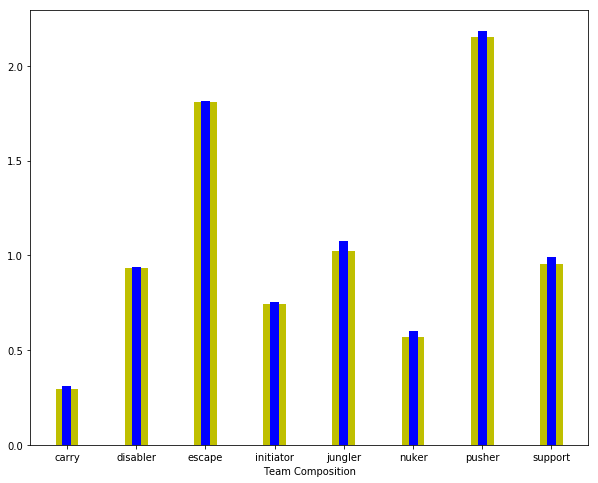

In [56]:
role_bits_df = role_bits_df.sort_values('role')
X = role_bits_df.index.tolist()
width = 0.33
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.bar(X,Y1,width,color='y',label='-Ymin')
ax.bar(X,Y2,width - 0.2,color='b',label='Ymax')
ax.set_xlabel('Team Composition')
plt.show()

In [57]:
Y1 = np.round(Y1)
Y1

array([0., 1., 1., 1., 2., 1., 2., 1.])

In [58]:
Y2 = np.round(Y2)
Y2

array([0., 1., 1., 1., 2., 1., 2., 1.])

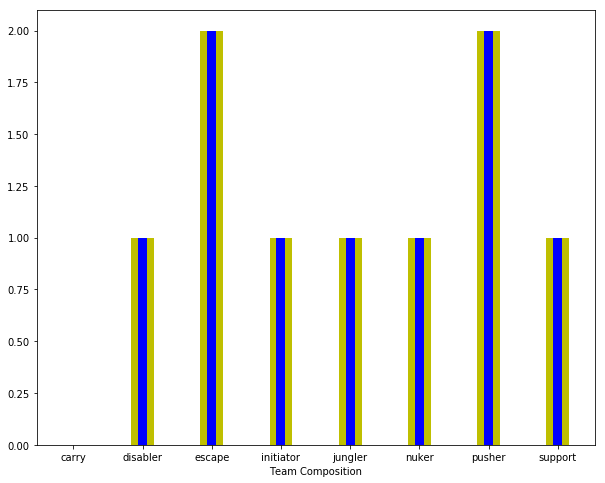

In [59]:
role_bits_df = role_bits_df.sort_values('role')
X = role_bits_df.index.tolist()
width = 0.33
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.bar(X,Y1,width,color='y',label='-Ymin')
ax.bar(X,Y2,width - 0.2,color='b',label='Ymax')
ax.set_xlabel('Team Composition')
plt.show()

**5 hero combos**

### 6.2.6 Most popular winning roles

In [60]:
from collections import Counter
win_team_list = win_team_composition['score'].tolist()
win_team_list = [y for x in win_team_list for y in x]
win_team_list = sorted(Counter(win_team_list).items())
win_team_list.sort(key=lambda x: x[1], reverse=True)
win_set = set([x[0] for x in win_team_list])

In [61]:
len(win_set)

45

### 6.2.7 Most popular losing roles

In [62]:
from collections import Counter
lose_team_list = lose_team_composition['score'].tolist()
lose_team_list = [y for x in lose_team_list for y in x]
lose_team_list = sorted(Counter(lose_team_list).items())
lose_team_list.sort(key=lambda x: x[1], reverse=True)
lose_set = set([x[0] for x in lose_team_list])

In [63]:
len(lose_set)

45

### 6.2.8 Comparing sets

In [64]:
win_set = [x[0] for x in win_team_list]
win_set = set(win_set[:8])

lose_set = [x[0] for x in lose_team_list]
lose_set = set(lose_set[:8])

In [65]:
win_diff = win_set.difference(lose_set)
win_diff

set()

In [66]:
lose_diff = lose_set.difference(win_set)
lose_diff

set()

## 6.2 Hero Win rates

In [67]:
win_df = player_df[player_df['win_lost'] == True]
win_hero_ratio = win_df.groupby('match_id').agg({'hero_win_ratio': lambda x: sorted(list(x))})
win_hero_ratio.head()

,hero_win_ratio
match_id,
3933472394,"[45.7152, 47.1554, 50.1353, 50.2428, 51.2784]"
3933472395,"[45.4935, 47.2532, 52.2677, 54.0256]"
3933472397,"[48.0791, 53.2352, 53.6806, 60.4767]"
3933472398,"[47.1554, 49.2443, 49.4947, 52.3461]"
3933472399,"[45.6277, 49.3308, 51.6418, 54.0256, 60.4767]"


In [68]:
win_ratio_list = win_hero_ratio['hero_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

50.134368001942214

In [69]:
win_ratio_list = win_hero_ratio['hero_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x[-2:]], dtype=float)
win_ratio_list.mean()

52.46179146666667

In [70]:
lose_df = player_df[player_df['win_lost'] == False]
lose_hero_ratio = lose_df.groupby('match_id').agg({'hero_win_ratio': lambda x: sorted(list(x))})
lose_hero_ratio.head()

,hero_win_ratio
match_id,
3933472394,"[44.9461, 47.9878, 52.2677]"
3933472395,"[48.4613, 49.8697, 50.2811, 50.3605, 53.5858]"
3933472397,"[50.933, 53.1647, 53.1903, 53.5858]"
3933472398,"[48.8041, 49.7256, 53.5858, 55.1821]"
3933472399,"[45.3665, 46.1426, 47.177, 47.8989, 47.9854]"


In [71]:
win_ratio_list = lose_hero_ratio['hero_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

49.67889785940161

In [72]:
win_ratio_list = lose_hero_ratio['hero_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x[-2:]], dtype=float)
win_ratio_list.mean()

51.94332126865672

## 6.3 Player win rate

In [73]:
win_df = player_df[player_df['win_lost'] == True]
player_win_ratio = win_df.groupby('match_id').agg({'win_ratio': lambda x: sorted(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,"[0.0, 50.1353, 50.41322, 51.2784, 61.538464]"
3933472395,"[45.4935, 47.2532, 52.2677, 54.0256]"
3933472397,"[37.5, 48.0791, 60.4767, 63.448273]"
3933472398,"[47.1554, 48.64865, 52.3461, 80.0]"
3933472399,"[45.6277, 49.3308, 53.198654, 54.83871, 62.666..."


In [74]:
win_ratio_list = player_win_ratio['win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

50.501231067249336

In [75]:
win_ratio_list = player_win_ratio['win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x[-2:]], dtype=float)
win_ratio_list.mean()

55.3386552096

In [76]:
lose_df = player_df[player_df['win_lost'] == False]
player_win_ratio = lose_df.groupby('match_id').agg({'win_ratio': lambda x: sorted(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,"[44.9461, 52.2677, 61.165047]"
3933472395,"[46.51163, 49.8697, 50.2811, 50.3605, 69.565216]"
3933472397,"[44.262295, 50.933, 53.1647, 53.1903]"
3933472398,"[33.333336, 48.8041, 49.7256, 55.1821]"
3933472399,"[45.3665, 53.846157, 58.823532, 64.28571, 70.3..."


In [77]:
win_ratio_list = player_win_ratio['win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

49.81986170688398

In [78]:
win_ratio_list = player_win_ratio['win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x[-2:]], dtype=float)
win_ratio_list.mean()

54.999193002132195

## 6.4 Best player per team

In [79]:
win_df = player_df[player_df['win_lost'] == True]
player_win_ratio = win_df.groupby('match_id').agg({'win_ratio': lambda x: max(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,61.538464
3933472395,54.0256
3933472397,63.448273
3933472398,80.0
3933472399,62.666668


In [80]:
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

58.249887220682304

In [81]:
lose_df = player_df[player_df['win_lost'] == False]
player_win_ratio = lose_df.groupby('match_id').agg({'win_ratio': lambda x: max(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,61.165047
3933472395,69.565216
3933472397,53.1903
3933472398,55.1821
3933472399,70.33898


In [82]:
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

57.966075777185495

## 6.5 Worst player per team

In [83]:
win_df = player_df[player_df['win_lost'] == True]
player_win_ratio = win_df.groupby('match_id').agg({'win_ratio': lambda x: min(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,0.0
3933472395,45.4935
3933472397,37.5
3933472398,47.1554
3933472399,45.6277


In [84]:
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

43.75404595948827

In [85]:
lose_df = player_df[player_df['win_lost'] == False]
player_win_ratio = lose_df.groupby('match_id').agg({'win_ratio': lambda x: min(list(x))})
player_win_ratio.head()

,win_ratio
match_id,
3933472394,44.9461
3933472395,46.51163
3933472397,44.262295
3933472398,33.333336
3933472399,45.3665


In [86]:
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

41.51164756396588

## 6.6 Player tendencies

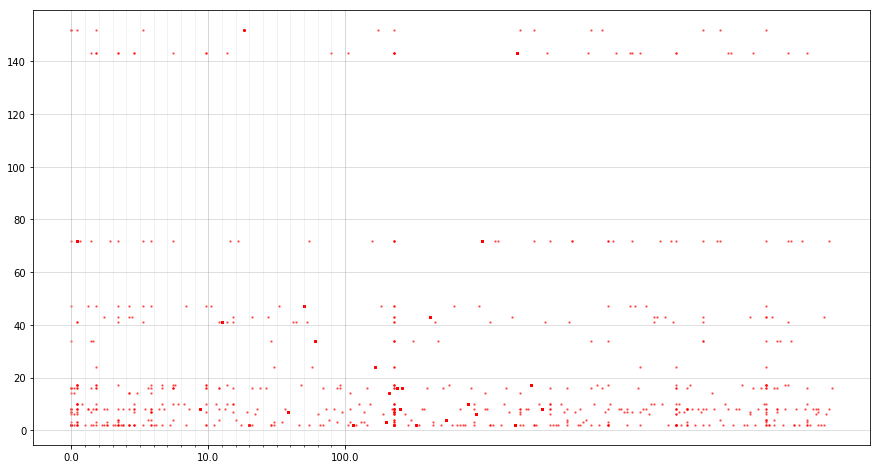

In [134]:
win_df = player_df[player_df['win_lost'] == True]
Y1 = win_df['score'].tolist()[:1500]
X1 = win_df['win_ratio'].tolist()[:1500]

lose_df = player_df[player_df['win_lost'] == False]
Y2 = lose_df['score'].tolist()[:1500]
X2 = lose_df['win_ratio'].tolist()[:1500]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 50)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

width = 2
ax.scatter(X1, Y1, width, color='r',label='Ymin', alpha = 0.5)

plt.show()

In [140]:
win_df['win_ratio'] = win_df['win_ratio'].astype(float)
win_df['win_ratio'].corr(win_df['score'])

/home/charmander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.008704729619483367

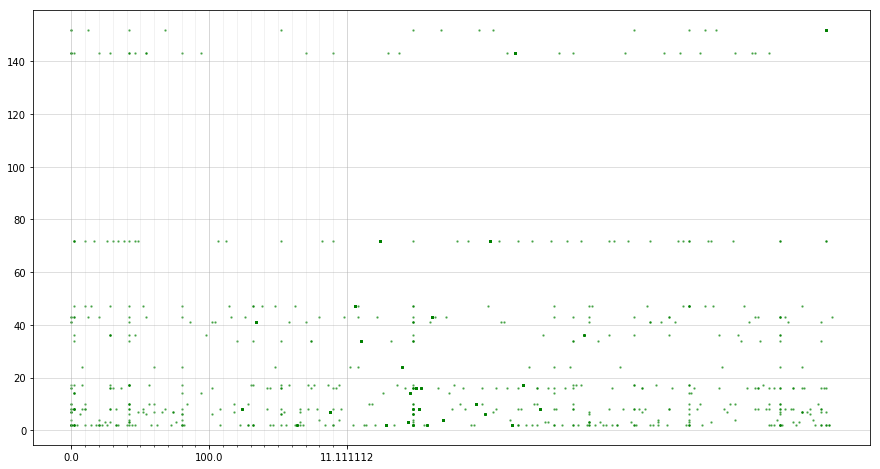

In [137]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 50)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

width = 2
ax.scatter(X2, Y2, width, color='g',label='Ymin', alpha = 0.5)

plt.show()

In [141]:
lose_df['win_ratio'] = lose_df['win_ratio'].astype(float)
lose_df['win_ratio'].corr(lose_df['score'])

/home/charmander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.01741662334817892

# 7. Machine Learning

In [262]:
win_df = player_df[player_df['win_lost'] == True]
win_data = win_df.groupby('match_id').agg({'hero_win_ratio': lambda x: list(x),
                                          'win_ratio': lambda x: list(x),
                                          'score': lambda x: list(x)})
win_data = win_data.values.tolist()

for i in range(len(win_data)):
    win_data[i] = win_data[i][0] + win_data[i][1] + win_data[i][2]

win_data = [x for x in win_data if len(x) == 15]
win_outcome = np.ones(len(win_data), dtype=int).tolist()

In [263]:
lose_df = player_df[player_df['win_lost'] == False]
lose_data = lose_df.groupby('match_id').agg({'hero_win_ratio': lambda x: list(x),
                                          'win_ratio': lambda x: list(x),
                                          'score': lambda x: list(x)})
lose_data = lose_data.values.tolist()

for i in range(len(lose_data)):
    lose_data[i] = lose_data[i][0] + lose_data[i][1] + lose_data[i][2]

lose_data = [x for x in lose_data if len(x) == 15]
lose_outcome = np.zeros(len(lose_data), dtype=int).tolist()

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = win_data + lose_data
Y = win_outcome + lose_outcome

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [286]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42) 
clf = LogisticRegression(C=1e5)
clf.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [287]:
y_predicted = clf.predict(x_test)
accuracy = np.sum(y_predicted == y_test) * 100.0 / len(y_test)
accuracy

55.78947368421053

In [288]:
(precision, recall, f1, _) = precision_recall_fscore_support(y_test, y_predicted)
precision

array([0.6025641 , 0.52678571])

In [289]:
 recall

array([0.47      , 0.65555556])

In [290]:
f1

array([0.52808989, 0.58415842])

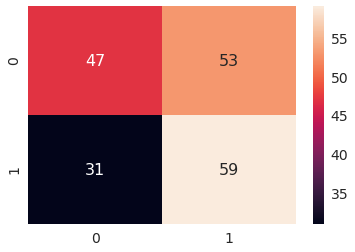

In [291]:
import seaborn as sn

cm = confusion_matrix(y_test, y_predicted)
df_cm = pd.DataFrame(cm, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size